# CNN MNIST Dataset

## Imports

In [1]:
import sklearn
import tensorflow as tf
import keras
from keras import datasets, layers, models
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import itertools
import io
from sklearn.metrics import plot_confusion_matrix
import io

## Dataset

### Load Dataset

In [36]:
digit_mnist = keras.datasets.mnist  # load dataset  keras.datasets.mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = digit_mnist.load_data()  # split into tetsing and training Data


class_names = ['Null', 'Eins', 'Zwei', 'Drei', 'Vier',
               'Fünf', 'Sechs', 'Sieben', 'Acht', 'Neun']

### Dataset Preprocessing

In [37]:
# reshape data (RGB change 1 to 3 Channels)
train_images = train_images.reshape(-1, 28,28, 1)
test_images = test_images.reshape(-1, 28,28, 1)

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# decrease values to 0-1    (Normalize)
train_images = train_images / 255.0
test_images = test_images / 255.0

### Show Dataset

Shape Testdata:  (10000, 28, 28, 1)
Shape Traindata: (60000, 28, 28, 1)


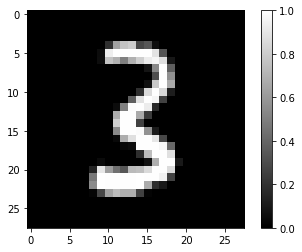

In [38]:
print(f"Shape Testdata:  {test_images.shape}")
print(f"Shape Traindata: {train_images.shape}")

plt.figure()
plt.imshow(train_images[50000], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

## Model

### Model Building

##### Model 1
- Activation = softmax (Dense Layer)

In [39]:
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(10, activation='softmax')
# ])
#
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # default value=0.001
#
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(),#from_logits=True    (not for softmax activation)
#               metrics=['accuracy'])
# model.summary()

##### Model 2
- Activation = relu (Dense Layer)

In [40]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # default value=0.001

              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#from_logits=True    (not for softmax activation)
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_3 (Flatten)         (None, 576)              

# TensorBoard

In [41]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [42]:
# Create log directory
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = keras.callbacks.TensorBoard(log_dir = logdir, histogram_freq = 1)

file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

In [43]:
def plot_to_image(figure):
    buf = io.BytesIO()
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')

    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)

    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)

    return image

In [44]:
def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(test_images)

    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)

    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## Model Training

In [45]:
# Start TensorBoard.
#%tensorboard --logdir logs/image

# Train the classifier.
history = model.fit(train_images,
          train_labels,
          epochs=10,
          verbose=0, # Suppress chatty output
          callbacks=[tensorboard_callback, cm_callback],
          validation_data=(test_images, test_labels))

313/313 [==============================] - 1s 2ms/step


## Testing

### Evaluate Accurancy

In [1]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

NameError: name 'model' is not defined

### Test Image Show Skript

In [ ]:
COLOR = 'black'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR

def predict(model, image, correct_label):
  class_names = ['Null', 'Eins', 'Zwei', 'Drei', 'Vier',
               'Fünf', 'Sechs', 'Sieben', 'Acht', 'Neun']
  prediction = model.predict(np.array([image]))
  predicted_class = class_names[np.argmax(prediction)]

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  plt.figure()
  imgX = img.reshape(28,28)
  plt.imshow(imgX, cmap=plt.cm.binary) #, cmap=plt.cm.binary
  plt.title("Expected: " + label)
  plt.xlabel("Guess: " + guess)
  plt.colorbar()
  plt.grid(False)
  plt.show()

def get_number():
  while True:
    num = input("Pick a number: ")
    if num.isdigit():
      num = int(num)
      if 0 <= num <= 1000:
        return int(num)
    else:
      print("Try again...")

num = get_number()
image = test_images[num]
label = test_labels[num]
predict(model, image, label)